# capcomm
##### A program to specify polygon or multipolygon shape and infer ecological community structure within based on species occurrence records.

In [1]:
import pandas as pd
import geopandas
import requests
import matplotlib.pyplot as plt
import folium
import capcomm
from pygbif import species

## Load data
converted original .shp files to .geojson using geopandas

In [ ]:
# "large-scale set" of mountain polygons (17 polygons represent largest continuous mountain ranges)
large = capcomm.data.load('large')
large.plot()

In [ ]:
# Mountain polygons for "entire_world" (1,048 polygons)
world = capcomm.data.load('world')
world.plot()
world[world.Country == "United States of America"].plot()

<AxesSubplot:>

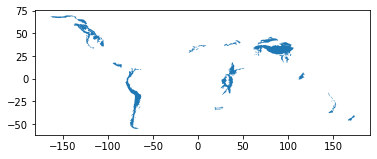

In [12]:
# create instance of Dataset class, which stores a list of Region class objects for each row in the GeoDataFrame
l = capcomm.Dataset(large)
l.gdf.plot()

West Coast


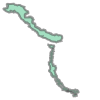

In [15]:
# view Region class at index 12 of Dataset class
print(l.region[12].name)
l.region[12].polygon

In [14]:
west_coast = l.region[12]
west_coast

## Test

In [ ]:
if __name__ == "__main__":

    # Read in mountain polygons
    world = geopandas.read_file("../data/geojson_files/world.geojson")

    # get example polygon (load with geopandas from ...)
    example_poly = world.geometry[778]

    # create example Polygon object
    region = Region(name="test", polygon=example_poly)
    print(region)

    # get json records from
    r = region.get_occurrences(taxa=6, tol=0.5)

    #convert to df and filter
    df = region.convert_json_to_dataframe(r)

    #plot
    region.plot_with_mpl(df)

In [2]:
# load in geojson for world mountain regions
world = capcomm.load('world')

<AxesSubplot:>

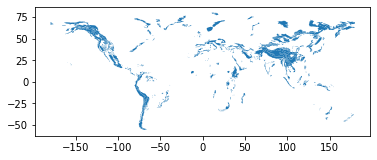

In [3]:
# create instance of Dataset class, which stores a list of Region class objects for each row in the GeoDataFrame
w = capcomm.Dataset(world)
w.gdf.plot()

           Name                   Country  \
905  Abajo Peak  United States of America   

                                              geometry  
905  POLYGON ((-110.15975 37.22858, -110.15813 37.3...  


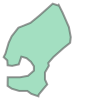

In [5]:
print(w.filter_name("Abajo Peak"))
w.region[905].polygon

In [6]:
# get example polygon (load with geopandas from ...)
example_poly = world.geometry[905]

In [10]:
# create example Region object
region = capcomm.Region(name="abajo", polygon=example_poly)
print(region)

In [12]:
# get occurrence records from GBIF and store as json
r = region.get_occurrences(kingdomkey=6, tol=0.5, limit=10)

In [ ]:
r

In [15]:
print(len(r["results"]))

10


In [22]:
json = region.get_all_occurrences(kingdomkey = 6, tol = 0.5)

...........Done. Found 3509 records


In [ ]:
json

In [ ]:
region.convert_json_to_dataframe(json)

In [2]:
class Region:
    """
    Polygon holds shape information for plotting a polygon, and a
    dataframe of points inside that polygon, and ...

    Parameters:
    -----------
    name:
    polygon: geojson polygon format object.
    """
    def __init__(self, name, polygon):
        self.name = name
        self.polygon = polygon

    
    def get_occurrences(self, taxonKey, offset=0, limit=20, tol=0.05):
        """
        Returns a GBIF REST query for occurrence records within
        self.polygon and between offset and offset + limit
        and return as JSON.
        """
        res = requests.get(
            url="https://api.gbif.org/v1/occurrence/search/",
            params={
                "taxonKey": taxonKey,
                "geometry": self.polygon.simplify(tolerance=tol),
                "hasCoordinate": "true",
                "offset": offset,
                "limit": limit,
               }
        )
        return res.json()
    
    
    def get_all_occurrences(self, taxonKey, tol):
        """
        Iterate requests over incremental offset positions until
        all records have been fetched. When the last record has
        been fetched the key 'endOfRecords' will be 'true'. Takes
        the API params as a dictionary. Returns result as a list
        of dictionaries.
        """
        # for storing results
        alldata = []
    
        # continue until we call 'break'
        offset = 0
        while 1:
        
            # get JSON data for a batch 
            jdata = self.get_occurrences(taxonKey, offset, 300, tol)
        
            # increment counter by 300 (the max limit)
            offset += 300
        
            # add this batch of data to the growing list
            alldata.extend(jdata["results"])
        
            # stop when end of record is reached
            if jdata["endOfRecords"]:
                print(f'Done. Found {len(alldata)} records')
                break
            
            # print a dot on each rep to show progress
            print('.', end='')
        
        return alldata


    def convert_json_to_dataframe(self, json):
        """
        json = get_occurrences_in_polygon()
        """

        #convert res.json() to pandas df
        df = pd.json_normalize(json)

        #filter df to include only species, latitude, longitude. 2 possible ways.
        #visit https://stackoverflow.com/questions/11285613/selecting-multiple-columns-in-a-pandas-dataframe
        #for further ways/explanations on how to organize dataframes to your liking!

        #1 - organize by column name
        newDf = df[["species", "decimalLatitude", "decimalLongitude"]]

        #2 - organize by column position (the bottom examples include columns 0 & 1)
        #newDf = df.iloc[:, 0:2] or
        #newDf = df.iloc[0, 0:2].copy() To avoid the case where changing df1 also changes df

        return newDf

    def plot_with_mpl(self, df):
        """
        I could not test this code to know if it works or not but it was taken
        from the documentation here which I think would be helpful for you! It
        specifically talks about longitude and latitude. Hopefully this code
        ends up working or helps!
        https://geopandas.org/gallery/create_geopandas_from_pandas.html
        """
        gdf = geopandas.GeoDataFrame(df, geometry=geopandas.points_from_xy(df.Longitude, df.Latitude))

        #visualize to make sure df is ok
        print(gdf.head())

        #get mountain area
        mtn = geopandas.read_file("Users/liortal/hacks/capcomm/data/GMBA_mountain_inventory_V1.2_entire_world/GMBA_Mountain_Inventory_v1.2-World.shp")

        #restrict to species?
        ax = mtn[mtn.species == 'groenlandica'].plot(color='white', edgecolor='black')

        # We can now plot our GeoDataFrame
        gdf.plot(ax=ax, color='red')
        plt.show()

    def convert_shape(self):
        """
        convert shapefile formats (e.g., .shp file to .geojson)
        """
        self.to_file("{self}.geojson", driver='GeoJSON')

In [3]:
class Dataset:
    """
    Create individual Region objects for each row of .geojson data
    """
    def __init__(self, gdf):       
        self.gdf = gdf
        self.region = [
            Region(name, poly) for name, poly in [
                gdf.iloc[i][["Name", "geometry"]]
                for i in range(len(gdf))]
        ]

    def filter_name(self, name=None):
        """
        subselect by name
        """
        fname = self.gdf[self.gdf.Name == name]
        return fname

    def filter_country(self, country=None):
        """
        subselect by country
        """
        fcountry = self.gdf[self.gdf.Country == country]
        return fcountry

In [4]:
world = geopandas.read_file('../data/geojson_files/world.geojson')

In [6]:
w = Dataset(world)

In [2]:
world = capcomm.load('world')

In [3]:
w = capcomm.Dataset(world)

<AxesSubplot:>

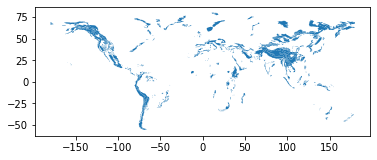

In [4]:
w.gdf.plot()

In [5]:
abajo = w.region[905]

In [ ]:
capcomm.taxon_info('Lupinus argenteus')

In [ ]:
# query GBIF for 5 occurrences of 'Lupinus argenteus' within the complete polygon of this mountain range
abajo.get_occurrences(taxonKey=2963774, limit=5, tol=0)

In [8]:
# query GBIF for all occurrences of 'Lupinus argenteus' within the complete polygon of this mountain range
a = abajo.get_all_occurrences(taxonKey=2963774, tol=0)

Done. Found 50 records


In [11]:
# query GBIF for all occurrences of 'Lupinus argenteus' within a simplified polygon of this mountain range (tol=0.5)
a = abajo.get_all_occurrences(taxonKey=2963774, tol=0.05)

Done. Found 44 records


In [9]:
a1 = abajo.get_all_occurrences(taxonKey=6, tol=0)

................Done. Found 4962 records


In [66]:
df = pd.json_normalize(r)
df.columns

Index(['offset', 'limit', 'endOfRecords', 'count', 'results', 'facets'], dtype='object')

In [ ]:
# convert to df and filter
df = pol.convert_json_to_dataframe(r)

In [ ]:
# plot
pol.plot_with_mpl(df)

# UX

In [12]:
# Read in polygons
world = geopandas.read_file("../data/GMBA_mountain_inventory_V1.2_entire_world/GMBA Mountain Inventory_v1.2-World.shp")
world[world.Country == "United States of America"]

,Name,Country,geometry
776,Aleutian Range,United States of America,"POLYGON ((-154.99707 59.27062, -154.98289 59.3..."
778,Alaska Range,United States of America,"POLYGON ((-147.10387 62.77209, -147.10387 62.8..."
781,Seward Peninsula,United States of America,"POLYGON ((-163.04917 64.73625, -163.54885 64.8..."
782,Kilbuck Mountains,United States of America,"POLYGON ((-161.85969 59.04392, -161.60007 59.0..."
784,Kenai Mountains,United States of America,"POLYGON ((-148.35599 60.13437, -148.38455 59.9..."
...,...,...,...
997,Kauai,United States of America,"POLYGON ((-159.60633 22.24246, -159.38742 22.1..."
998,Kodiak and Afognak Island,United States of America,"POLYGON ((-154.35224 57.73159, -153.90966 57.9..."
1000,Alexander Archipelago,United States of America,"MULTIPOLYGON (((-131.91511 54.99521, -131.9722..."
1004,Sawatch Range,United States of America,"POLYGON ((-106.08813 38.72114, -106.06459 38.5..."


### explicit use of Polygon class object

In [28]:
alaska = Polygon(name="alaska", polygon=world.geometry[world.Name == "Alaska Range"])
alaska.get_occurrences_in_polygon(tol = 0.5)

{'offset': 0,
 'limit': 100,
 'endOfRecords': False,
 'count': 23455,
 'results': [{'key': 2813898723,
   'datasetKey': '50c9509d-22c7-4a22-a47d-8c48425ef4a7',
   'publishingOrgKey': '28eb1a3f-1c15-4a95-931a-4af90ecb574d',
   'installationKey': '997448a8-f762-11e1-a439-00145eb45e9a',
   'publishingCountry': 'US',
   'protocol': 'DWC_ARCHIVE',
   'lastCrawled': '2021-03-21T07:12:09.319+00:00',
   'lastParsed': '2021-03-21T08:48:08.429+00:00',
   'crawlId': 256,
   'hostingOrganizationKey': '28eb1a3f-1c15-4a95-931a-4af90ecb574d',
   'extensions': {'http://rs.gbif.org/terms/1.0/Multimedia': [{'http://purl.org/dc/terms/format': 'image/jpeg',
      'http://purl.org/dc/terms/license': 'http://creativecommons.org/licenses/by-nc/4.0/',
      'http://purl.org/dc/terms/created': '2020-04-26T21:51:23Z',
      'http://purl.org/dc/terms/rightsHolder': 'jdmason',
      'http://purl.org/dc/terms/type': 'StillImage',
      'http://rs.tdwg.org/dwc/terms/catalogNumber': '80748950',
      'http://purl.or

In [34]:
# to investigate length of geometry string issue when querying GBIF (supposedly string can't be larger than 1500)
# seems like the hard limit is 5000 characters
def length(idx):
    x = world.geometry[idx]
    length = len(str(x))
    return length

In [35]:
length(778)

13042

# Geographical vector objects
#### https://eaton-lab.org/hack-the-planet/tutorials/25.1-folium-vectors.html

In [1]:
import folium
import geopandas
import shapely
import pyproj
import geojson

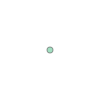

In [4]:
# create a Point instance
shapely.geometry.Point(44.0, -74.5)

# create a Polygon instance
#shapely.geometry.Polygon([
#    (44.0, -74), (45.0, -75), (45.0, -76), (43.0, -76),
#])

In [5]:
# create two points
point1 = shapely.geometry.Point(44.0, -74.5)
point2 = shapely.geometry.Point(43.0, -73.5)

# get linear distance between points
linear_dist = point1.distance(point2)
print(f"linear unit-less distance: {linear_dist:.2f}")

linear unit-less distance: 1.41


In [6]:
# get geodetic (great circle) projection object
geod = pyproj.Geod(ellps='WGS84')

# get results of projecting points to new space
angle1, angle2, distance = geod.inv(point1.x, point1.y, point2.x, point2.y)

# print results (divide by 1000 to get in units of kms)
print(f"WGS84 distance in Kilometers: {distance / 1000:.2f}")

WGS84 distance in Kilometers: 115.77


In [26]:
# fetch feature data from a large GeoJson file from a URL
geodata = geopandas.read_file("https://datahub.io/core/geo-ne-admin1/r/0.geojson")

# show the shape of the dataframe
print(geodata.shape)

# show the header of the dataframe
geodata.head()

(4647, 5)


,ISO3166-1-Alpha-3,country,id,name,geometry
0,ABW,Aruba,5150,Aruba,"POLYGON ((-69.99694 12.57758, -69.93639 12.531..."
1,AFG,Afghanistan,1741,Badghis,"POLYGON ((64.30624 35.39722, 64.32468 35.40177..."
2,AFG,Afghanistan,1742,Hirat,"POLYGON ((61.36393 35.59824, 61.36548 35.59850..."
3,AFG,Afghanistan,1743,Bamyan,"POLYGON ((67.74391 35.44342, 67.75476 35.44412..."
4,AFG,Afghanistan,1744,Balkh,"POLYGON ((67.25913 37.18515, 67.28145 37.18866..."


In [29]:
# init a map instance
fmap = folium.Map()

# create a layer to hold several features
region = folium.FeatureGroup(name="Afghanistan")

# iterate over rows of 
for idx in geodata[geodata.country == "Afghanistan"].index:
    
    # init a GeoJson object from each geometry datum and add to afghan layer
    data = folium.GeoJson(
        data=geodata.loc[idx, "geometry"],
        tooltip=geodata.loc[idx, "name"],
    ).add_to(region)   
    
# add layer to the map
fmap.add_child(region)

# set bounds (location and zoom) on map to center on this region
fmap.fit_bounds(region.get_bounds())

# add layer toggle option
fmap.add_child(folium.LayerControl())

# show map
fmap

# add function to display how tolerance parameter will affect geometry object passed to GBIF for query

In [15]:
from math import sqrt
from shapely import affinity

GM = (sqrt(5)-1.0)/2.0
W = 8.0
H = W*GM
SIZE = (W, H)

BLUE = '#6699cc'
GRAY = '#999999'
DARKGRAY = '#333333'
YELLOW = '#ffcc33'
GREEN = '#339933'
RED = '#ff3333'
BLACK = '#000000'

COLOR_ISVALID = {
    True: BLUE,
    False: RED,
}

def plot_line(ax, ob, color=GRAY, zorder=1, linewidth=3, alpha=1):
    x, y = ob.xy
    ax.plot(x, y, color=color, linewidth=linewidth, solid_capstyle='round', zorder=zorder, alpha=alpha)

def plot_coords(ax, ob, color=GRAY, zorder=1, alpha=1):
    x, y = ob.xy
    ax.plot(x, y, 'o', color=color, zorder=zorder, alpha=alpha)

def color_isvalid(ob, valid=BLUE, invalid=RED):
    if ob.is_valid:
        return valid
    else:
        return invalid

def color_issimple(ob, simple=BLUE, complex=YELLOW):
    if ob.is_simple:
        return simple
    else:
        return complex

def plot_line_isvalid(ax, ob, **kwargs):
    kwargs["color"] = color_isvalid(ob)
    plot_line(ax, ob, **kwargs)

def plot_line_issimple(ax, ob, **kwargs):
    kwargs["color"] = color_issimple(ob)
    plot_line(ax, ob, **kwargs)

def plot_bounds(ax, ob, zorder=1, alpha=1):
    x, y = zip(*list((p.x, p.y) for p in ob.boundary))
    ax.plot(x, y, 'o', color=BLACK, zorder=zorder, alpha=alpha)

def add_origin(ax, geom, origin):
    x, y = xy = affinity.interpret_origin(geom, origin, 2)
    ax.plot(x, y, 'o', color=GRAY, zorder=1)
    ax.annotate(str(xy), xy=xy, ha='center',
                textcoords='offset points', xytext=(0, 8))

def set_limits(ax, x0, xN, y0, yN):
    ax.set_xlim(x0, xN)
    ax.set_xticks(range(x0, xN+1))
    ax.set_ylim(y0, yN)
    ax.set_yticks(range(y0, yN+1))
    ax.set_aspect("equal")

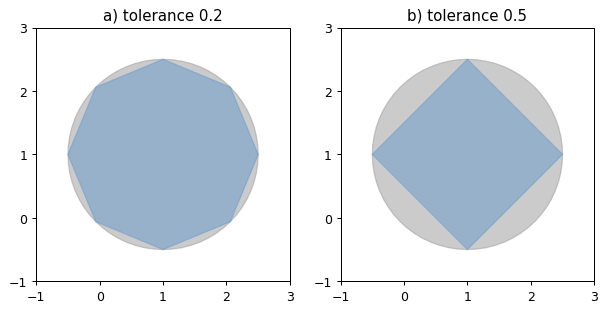

In [16]:
from matplotlib import pyplot
from shapely.geometry import MultiPoint, Point
from descartes.patch import PolygonPatch

#from shapely.figures import SIZE, BLUE, GRAY, set_limits

fig = pyplot.figure(1, figsize=SIZE, dpi=90) #1, figsize=SIZE, dpi=90)

p = Point(1, 1).buffer(1.5)

# 1
ax = fig.add_subplot(121)

q = p.simplify(0.2)

patch1a = PolygonPatch(p, facecolor=GRAY, edgecolor=GRAY, alpha=0.5, zorder=1)
ax.add_patch(patch1a)

patch1b = PolygonPatch(q, facecolor=BLUE, edgecolor=BLUE, alpha=0.5, zorder=2)
ax.add_patch(patch1b)

ax.set_title('a) tolerance 0.2')

set_limits(ax, -1, 3, -1, 3)

#2
ax = fig.add_subplot(122)

r = p.simplify(0.5)

patch2a = PolygonPatch(p, facecolor=GRAY, edgecolor=GRAY, alpha=0.5, zorder=1)
ax.add_patch(patch2a)

patch2b = PolygonPatch(r, facecolor=BLUE, edgecolor=BLUE, alpha=0.5, zorder=2)
ax.add_patch(patch2b)

ax.set_title('b) tolerance 0.5')

set_limits(ax, -1, 3, -1, 3)

pyplot.show()